<a href="https://colab.research.google.com/github/karavdin/retail_demand_forecast/blob/main/LSTM_forecasting_multiple_stores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all libraries we will need

In [3]:
import pandas as pd
from pandas import get_dummies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import mean_squared_error

# Connect to Goole Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the files with pandas

In [5]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

#Note: train file is very large.
#To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', nrows=2.5e7)
# Convert 'date' column to datetime in the train dataset
df_train['date'] = pd.to_datetime(df_train['date'])

<ipython-input-5-7e0168dd62ad>:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', nrows=2.5e7)


In [6]:
df_items['item_nbr'].nunique()

4100

In [7]:
df_stores['store_nbr'].nunique()

54

In [8]:
df_stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
df_items.head(5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


# Prepare data

In [10]:
#store_list = [1, 2]  # Example: store 1 and store 2
#item_list = [96995, 838216]  # Example: item 96995 and item 838216
## Filter data for specific stores and items (can be extended to all)
#df_filtered = df_train[(df_train['store_nbr'].isin(store_list)) & (df_train['item_nbr'].isin(item_list))]

#store_list = [1, 2]  # Example: store 1 and store 2
store_list = df_stores['store_nbr'].unique()
item_list = [96995]  # Example: item 96995
# Filter data for all stores with the item sales
df_filtered = df_train[(df_train['item_nbr'].isin(item_list))]

# Aggregate sales by store, item, and date
df_filtered = df_filtered.groupby(['store_nbr', 'item_nbr', 'date']).sum()['unit_sales'].reset_index()

# Merge df_filtered with df_store and df_item on store_nbr and item_nbr, respectively
df_filtered = df_filtered.merge(df_stores, on='store_nbr', how='left').merge(df_items, on='item_nbr', how='left')

# Convert 'date' to datetime format and sort by 'date' for each store-item combination
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered = df_filtered.sort_values(by=['store_nbr', 'item_nbr', 'date'])

# Set up continuous date ranges for each store-item combination and fill missing sales with zero
all_combinations = []
for store in store_list:
    for item in item_list:
        df_combo = df_filtered[(df_filtered['store_nbr'] == store) & (df_filtered['item_nbr'] == item)]
        df_combo.set_index('date', inplace=True)
        df_combo = df_combo.asfreq('D').fillna(0)  # Fill missing dates with zero sales
        df_combo['store_nbr'] = store
        df_combo['item_nbr'] = item
        all_combinations.append(df_combo)

# Concatenate all combinations back into a single DataFrame
df_full = pd.concat(all_combinations).reset_index()
print(df_full.head())

        date  store_nbr  item_nbr  unit_sales   city      state type  cluster  \
0 2013-01-10          1     96995         1.0  Quito  Pichincha    D     13.0   
1 2013-01-11          1     96995         1.0  Quito  Pichincha    D     13.0   
2 2013-01-12          1     96995         0.0      0          0    0      0.0   
3 2013-01-13          1     96995         0.0      0          0    0      0.0   
4 2013-01-14          1     96995         1.0  Quito  Pichincha    D     13.0   

      family   class  perishable  
0  GROCERY I  1093.0         0.0  
1  GROCERY I  1093.0         0.0  
2          0     0.0         0.0  
3          0     0.0         0.0  
4  GROCERY I  1093.0         0.0  


# Preprocessing the Data for LSTM

## Transform the features

In [11]:
# One-hot encode categorical features: 'city', 'state', 'type', 'family', 'cluster', and 'class'
df_full = pd.get_dummies(df_full, columns=['city', 'state', 'type', 'family', 'cluster', 'class'])
# Convert 'perishable' to binary
df_full['perishable'] = df_full['perishable'].astype(int)
# Scale unit_sales and drop non-encoded columns if necessary
scaler = MinMaxScaler()
df_full['unit_sales'] = scaler.fit_transform(df_full[['unit_sales']])


## Split in test and train

In [12]:
# Define the split date
split_date = '2014-03-01'

# Split df_full into train and test sets based on the split date
train = df_full[df_full['date'] < split_date]
#test = df_full[df_full['date'] >= split_date]

## Create Sequences for LSTM with Multiple Features

In [13]:
# Function to create sequences with all features for LSTM
def create_sequences_with_features(df, sequence_length):
    X, y = [], []
    unique_combos = df[['store_nbr', 'item_nbr']].drop_duplicates()

    for _, combo in unique_combos.iterrows():
        store = combo['store_nbr']
        item = combo['item_nbr']

        # Filter for specific store-item combination
        df_combo = df[(df['store_nbr'] == store) & (df['item_nbr'] == item)]

        # Drop non-numeric columns and convert to numpy array
        combo_data = df_combo.drop(columns=['store_nbr', 'item_nbr', 'date']).values

        # Create sequences
        for i in range(len(combo_data) - sequence_length):
            X.append(combo_data[i:i + sequence_length])  # sequence of all features
            y.append(combo_data[i + sequence_length, 0])  # target is the next step's sales (first column)

    X = np.array(X)
    y = np.array(y)

    return X, y

# Generate sequences
X_train, y_train = create_sequences_with_features(train, sequence_length=60)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

print("Shape of X_train:", X_train.shape)  # Expected shape: (samples, sequence_length, num_features)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (7934, 60, 42)
Shape of y_train: (7934,)


# LSTM model

## Define and train the model

In [14]:
# Define the LSTM model
model = Sequential([
    # First LSTM layer with return_sequences=True to pass the sequence to the next LSTM layer
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Dropout for regularization

    # Second LSTM layer, also with return_sequences=True
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),

    # Third LSTM layer, without return_sequences (final LSTM layer in the stack)
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),

    # # Dense layers for further learning after the LSTMs
    # Dense(32, activation='relu'),
    # Dense(16, activation='relu'),

    # Output layer to predict sales (single output)
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stop])
# Display model summary
model.summary()

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 7.9345e-04 - val_loss: 2.6275e-05
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 9.4395e-05 - val_loss: 2.6164e-05
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - loss: 5.7649e-04 - val_loss: 2.6171e-05
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 2.7223e-05 - val_loss: 2.7025e-05
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - loss: 1.3668e-04 - val_loss: 2.6269e-05
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - loss: 3.0725e-05 - val_loss: 2.6388e-05
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - loss: 3.3887e-05 - val_loss: 2.6120e-05
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - loss: 1.8600e-04 - val_loss: 2.6155e-05
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - loss: 2.7725e-04 - val_loss: 2.6151e-05
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - loss: 2.4630e-05 - val_loss: 2.7660e-05


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          27,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 60, 1)               │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,597 (853.90 KB)

 Trainable params: 72,865 (284.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 145,732 (569.27 KB)

## Make Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


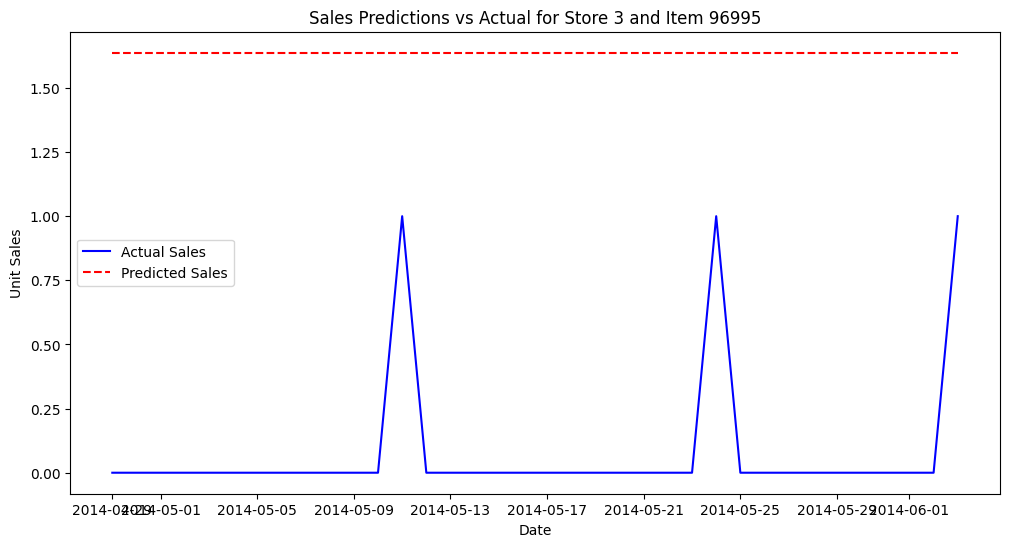

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


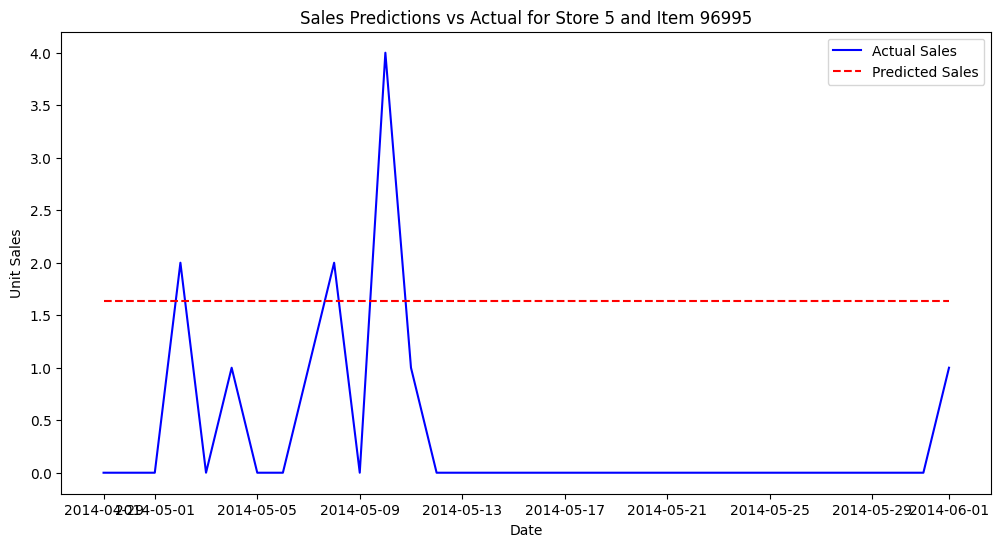

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


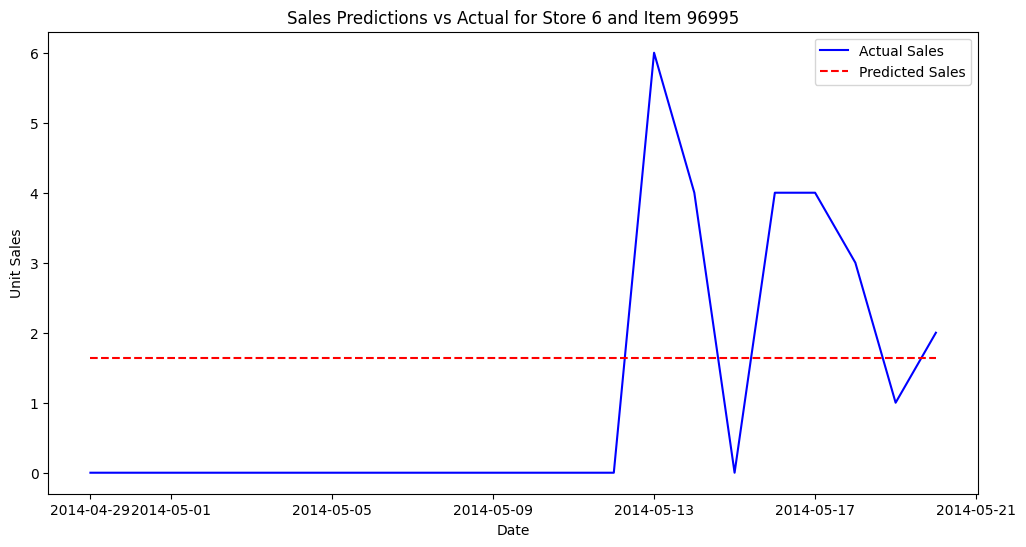

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


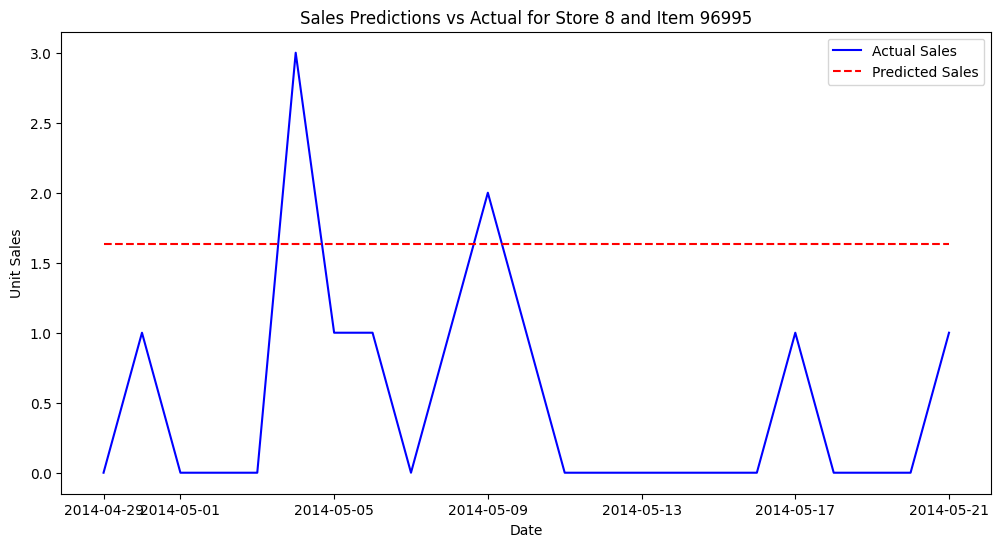

Skipping store 24, item 96995 due to insufficient data.
Skipping store 36, item 96995 due to insufficient data.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


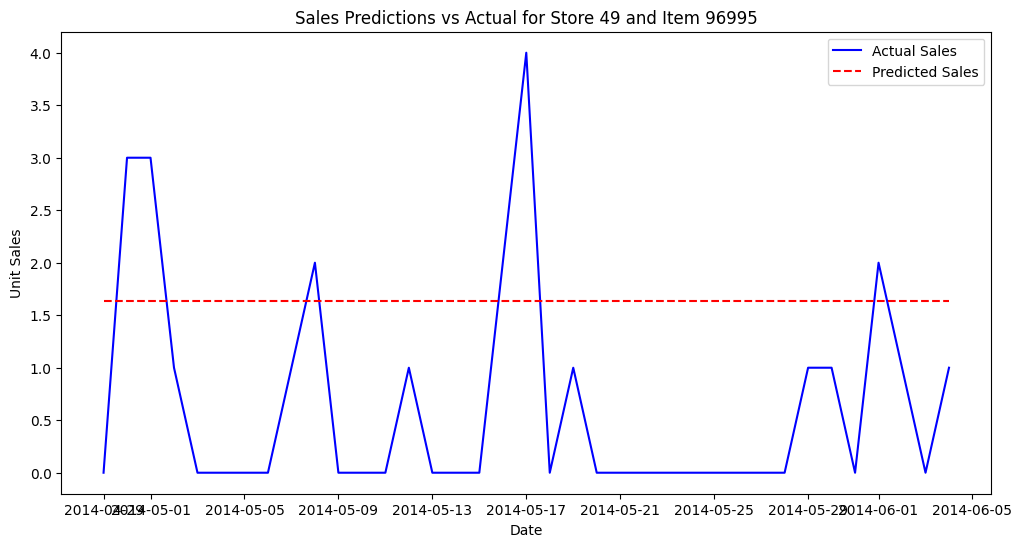

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
rMAD 1.4870470798151392
Bias 1.172910151654051
RMSE 1.561411367873639


In [19]:
# Define sequence length and number of features based on training data
sequence_length = X_train.shape[1]
num_features = X_train.shape[2]

# If X_train is a NumPy array, convert it to DataFrame to get column names (assuming X_train was built from a DataFrame initially)
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train.reshape(-1, num_features))
else:
    X_train_df = X_train

# Extract expected columns from X_train
expected_columns = X_train_df.columns.tolist()

# Initialize lists to store metrics for each store-product pair
rmad_values = []
bias_values = []
rmse_values = []

plot_counts = 0

# Loop over each store-product pair in the test set
for (item_nbr, store_nbr), group in df_full[df_full['date'] >= split_date].groupby(['item_nbr', 'store_nbr']):
    # Prepare features and target for the selected pair
    X_test_pair = group.drop(['unit_sales', 'date', 'store_nbr', 'item_nbr'], axis=1)

    # Ensure X_test_pair has the same columns as X_train
    X_test_pair = X_test_pair.reindex(columns=expected_columns, fill_value=0)

    # Convert X_test_pair and y_test_pair to arrays
    X_test_pair = X_test_pair.values
    y_test_pair = group['unit_sales'].values

    # Check if there's enough data to create at least one sequence
    if X_test_pair.shape[0] < sequence_length:
        print(f"Skipping store {store_nbr}, item {item_nbr} due to insufficient data.")
        continue

    # Generate sliding window sequences
    X_test_seq = []
    y_test_seq = []
    for i in range(len(X_test_pair) - sequence_length + 1):
        X_test_seq.append(X_test_pair[i:i + sequence_length])
        y_test_seq.append(y_test_pair[i + sequence_length - 1])  # Target is the next sales value after the sequence

    # Convert to NumPy arrays and ensure float32 type for prediction
    X_test_seq = np.array(X_test_seq, dtype=np.float32)
    y_test_seq = np.array(y_test_seq, dtype=np.float32)

    # Make predictions on the test pair data
    predictions_pair = model.predict(X_test_seq)

    # Reshape predictions to 2D (taking only the last time step's predictions)
    predictions_pair = predictions_pair[:, -1, :]

    # Rescale predictions and actual values
    predictions_pair_rescaled = scaler.inverse_transform(
        np.concatenate((predictions_pair, np.zeros((predictions_pair.shape[0], num_features - 1))), axis=1)
    )[:, 0]
    y_test_seq_rescaled = scaler.inverse_transform(
        np.concatenate((y_test_seq.reshape(-1, 1), np.zeros((y_test_seq.shape[0], num_features - 1))), axis=1)
    )[:, 0]

    # Calculate metrics for this store-item pair
    bias = np.mean(predictions_pair_rescaled - y_test_seq_rescaled)
    rmad = np.mean(np.abs(predictions_pair_rescaled - y_test_seq_rescaled))
    rmse = np.sqrt(mean_squared_error(y_test_seq_rescaled, predictions_pair_rescaled))

    # Append metrics to their respective lists
    bias_values.append(bias)
    rmad_values.append(rmad)
    rmse_values.append(rmse)

    # Plot predictions vs actual values for the current store-product pair
    if plot_counts < 5: #plot the first 5 plots only
      plt.figure(figsize=(12, 6))
      plt.plot(group['date'].iloc[sequence_length - 1:], y_test_seq_rescaled, label='Actual Sales', color='blue')
      plt.plot(group['date'].iloc[sequence_length - 1:], predictions_pair_rescaled, label='Predicted Sales', color='red', linestyle='--')
      plt.xlabel('Date')
      plt.ylabel('Unit Sales')
      plt.title(f'Sales Predictions vs Actual for Store {store_nbr} and Item {item_nbr}')
      plt.legend()
      plt.show()
      plot_counts = plot_counts+1

print("rMAD", sum(rmad_values)/len(rmad_values)) #average rMAD
print("Bias", sum(bias_values)/len(bias_values)) #average Bias
print("RMSE", sum(rmse_values)/len(rmse_values)) #average RMSE
